In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_optimization_lib as gmm_optim_lib
from bnpgmm_runjingdev import gmm_posterior_quantities_lib

# BNP libraries
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_cross_hess
from bnpmodeling_runjingdev import result_loading_utils, influence_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import influence_function_utils
import gmm_loading_utils

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

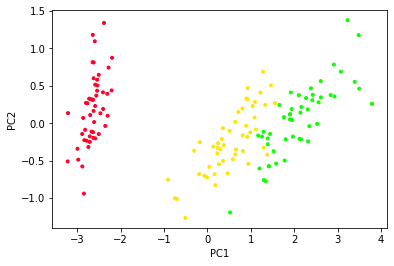

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# file paths

In [5]:
out_folder = '../fits/'
out_filename = 'iris_fit'

In [6]:
alpha0 = 6.0

# Load initial fit

In [7]:
init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
print(init_fit_file)

../fits/iris_fit_alpha6.0.npz


In [8]:
vb_opt, vb_opt_dict, e_z_opt, \
 vb_params_paragami, \
    prior_params_dict, \
        gh_loc, gh_weights = gmm_loading_utils.load_initial_fit(init_fit_file, iris_obs)

In [9]:
assert prior_params_dict['dp_prior_alpha'] == alpha0

### Check results

In [10]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[np.unique(bnp_clusters), :], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


In [11]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_opt_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_opt_dict['cluster_params']['cluster_info']))

### Plot centroids

Text(0, 0.5, 'PC2')

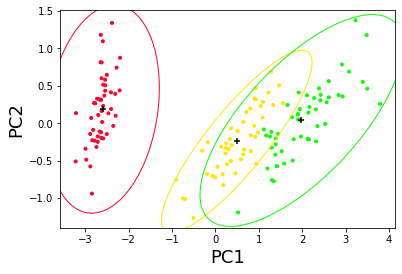

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [13]:
def get_e_num_obs_per_cluster(vb_params_dict): 
    ez = gmm_posterior_quantities_lib.get_optimal_z_from_vb_dict(iris_obs,
                               vb_params_dict,
                               gh_loc,
                               gh_weights,
                               use_bnp_prior = True)
    return ez.sum(0)

In [14]:
e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt_dict)
mixture_weights = gmm_posterior_quantities_lib.get_e_mixture_weights_from_vb_dict(vb_opt_dict, gh_loc, gh_weights)

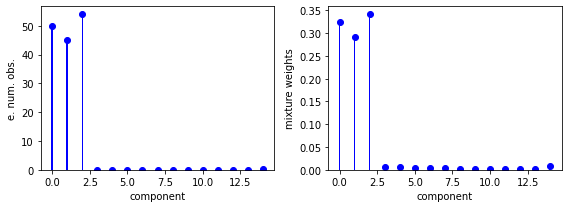

In [15]:
fig, axarr = plt.subplots(1, 2, figsize = (8, 3))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()

# Some wrappers to compute the influence function and posterior statistics

In [16]:
# contains methods to compute influence functions. 
# this compiles the hessian solver, so takes about a minute
infl_funs = influence_function_utils.InfluenceFunctions(iris_obs, 
                                                       vb_opt, 
                                                       vb_params_paragami, 
                                                       prior_params_dict, 
                                                       gh_loc, gh_weights)

Compiling hessian solver ...
Hessian solver compile time: 59.0431sec

Compiling cross hessian...
Cross-hessian compile time: 0.678323sec

LR sensitivity time: 0.0196447sec



In [17]:
# contains the posterior statistics
post_stats = influence_function_utils.PosteriorStatistics(iris_obs, 
                                                          vb_params_paragami, 
                                                          gh_loc, 
                                                          gh_weights)

# Influence functions

### Influence function on mixture weights

In [18]:
logit_v_grid = np.linspace(-8, 8, 500)

In [19]:
e_num_ind_results = dict()
for k in range(4): 
    print('##############')
    print('Computing influence for k = {}'.format(k))
    print('##############')
    
    influence_grid, influence_grid_x_prior, ghess = infl_funs.get_influence(lambda x : post_stats.get_mixture_weight_k(x, k), 
                                                                           logit_v_grid)
    
    e_num_ind_results['influence_grid{}'.format(k)] = influence_grid
    e_num_ind_results['influence_grid_x_prior{}'.format(k)] = influence_grid_x_prior
    e_num_ind_results['ghess{}'.format(k)] = ghess
    print('\n')

##############
Computing influence for k = 0
##############
computing gradient ...
Elapsed: 1.996sec
inverting Hessian (twice) ...
Elapsed: 5.936sec


##############
Computing influence for k = 1
##############
computing gradient ...
Elapsed: 0.935sec
inverting Hessian (twice) ...
Elapsed: 2.657sec


##############
Computing influence for k = 2
##############
computing gradient ...
Elapsed: 1.150sec
inverting Hessian (twice) ...
Elapsed: 2.658sec


##############
Computing influence for k = 3
##############
computing gradient ...
Elapsed: 0.942sec
inverting Hessian (twice) ...
Elapsed: 2.647sec




In [20]:
def plot_influence_grid(influence_grid, influence_grid_x_prior, ax): 
    
    # plot y = 0 line
    for i in range(3): 
        ax[i].axhline(0, color = 'black')
    
    # plot influence function
    ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')
    
    # plot prior
    ax[1].plot(logit_v_grid,
               influence_function_utils.p0(logit_v_grid, alpha0), 
               color = '#7bccc4')
    
    # plot influence x prior
    ax[2].plot(logit_v_grid, influence_grid_x_prior, color = '#0868ac')
        
    ax[0].set_ylabel('influence')
    ax[1].set_ylabel('prior')
    ax[2].set_ylabel('influence x prior')

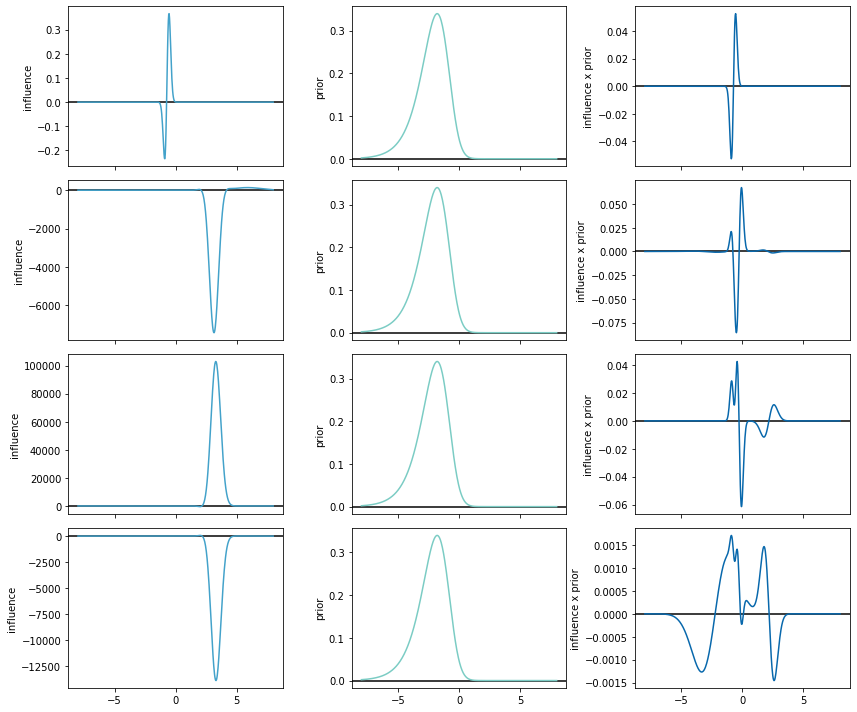

In [21]:
fig, axarr = plt.subplots(4, 3, figsize = (12, 10),  sharex = True) 
for k in range(4): 
    plot_influence_grid(e_num_ind_results['influence_grid{}'.format(k)],
                        e_num_ind_results['influence_grid_x_prior{}'.format(k)],
                        axarr[k])
fig.tight_layout()

### Influence function on expected number of clusters

In [22]:
# in sample
infl_num_clust, infl_x_prior_num_clust, ghess_num_clust = \
    infl_funs.get_influence(post_stats.get_n_clusters_insample, 
                            logit_v_grid)

# predictive
infl_num_clust_pred, infl_x_prior_num_clust_pred, ghess_num_clust_pred = \
    infl_funs.get_influence(post_stats.get_n_clusters_pred,
                            logit_v_grid)

computing gradient ...
Elapsed: 6.982sec
inverting Hessian (twice) ...
Elapsed: 2.633sec
computing gradient ...
Elapsed: 3.297sec
inverting Hessian (twice) ...
Elapsed: 2.604sec


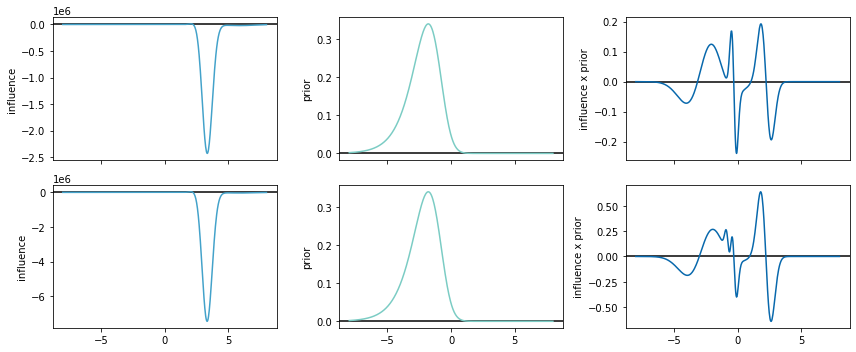

In [23]:
fig, axarr = plt.subplots(2, 3, figsize = (12, 5),  sharex = True) 

plot_influence_grid(infl_num_clust,
                    infl_x_prior_num_clust,
                    axarr[0])

plot_influence_grid(infl_num_clust_pred,
                    infl_x_prior_num_clust_pred,
                    axarr[1])


fig.tight_layout()

#  Load refitted vb parameters

In [24]:
num_mus = 12

In [25]:
def _load_refit_results_for_mu(mu_indx): 
    match_crit = out_filename + '_inflbump_mu{}_eps'.format(mu_indx) + '\d+.npz'
    
    # load free parameters
    vb_refit_list, epsilon_vec, meta_data_list = \
        result_loading_utils.load_refit_files_epsilon(out_folder, match_crit)
    
    # get mu
    mus = result_loading_utils._load_meta_data_from_list(meta_data_list, 'mu')
    mu = np.unique(mus)
    assert len(mu) == 1
    
    # check prior parameter matches
    assert np.all(result_loading_utils._load_meta_data_from_list(meta_data_list, 'dp_prior_alpha') == \
                  alpha0)
    
    return vb_refit_list, epsilon_vec, mu

In [26]:
def load_all_refit_results(): 
    
    mu_vec = onp.zeros(num_mus)
    
    for mu_indx in range(num_mus): 
        vb_refit_list, _epsilon_vec, mu= _load_refit_results_for_mu(mu_indx)
        
        if mu_indx == 0: 
            epsilon_vec = deepcopy(_epsilon_vec)
            vb_refit_array = onp.zeros((num_mus, len(epsilon_vec), vb_refit_list.shape[-1]))
            
        assert np.all(epsilon_vec == _epsilon_vec)
            
        vb_refit_array[mu_indx] = vb_refit_list
        mu_vec[mu_indx] = mu
        
    return np.array(vb_refit_array), epsilon_vec, mu_vec

In [27]:
vb_refit_array, epsilon_vec, _mu_vec = load_all_refit_results()
print(_mu_vec)

[-6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


In [28]:
mu_vec = np.concatenate((_mu_vec, np.array([_mu_vec[-1] + 1])))
print(mu_vec)

[-6. -5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.]


### For plotting, define step bumps

In [29]:
def step_bump(x, mu_indx):    
    return (x > mu_vec[mu_indx]) & (x <= mu_vec[mu_indx+1])


In [30]:
# analytic expectations since we are just perturbing with step functions

def e_step_bump(means, infos, mu_indx): 
    cdf1 = sp.stats.norm.cdf(mu_vec[mu_indx+1], loc = means, scale = 1 / np.sqrt(infos))
    cdf2 = sp.stats.norm.cdf(mu_vec[mu_indx], loc = means, scale = 1 / np.sqrt(infos))
    
    return (cdf1 - cdf2).sum()


# Function to compute posterior statistic on all refits

In [31]:
def get_refit_g_array(g): 
    
    refit_g_array = onp.zeros(vb_refit_array.shape[0:2])
    
    for i in range(refit_g_array.shape[0]): 
        for j in range(refit_g_array.shape[1]): 
            
            refit_g_array[i, j] = g(vb_refit_array[i, j])
        
    return refit_g_array

# Compute cross-hessians

One cross-hessian for each mu

In [32]:
cross_hess_list = []

for i in range(len(mu_vec) - 1): 
    # compute linear response stuff
    f_obj = func_sens_lib.FunctionalPerturbationObjective(None, 
                                                          vb_params_paragami, 
                                                          e_log_phi = lambda x,y : e_step_bump(x,y,i), 
                                                          gh_loc = gh_loc, 
                                                          gh_weights = gh_weights, 
                                                          stick_key = 'stick_params')

    cross_hess = get_cross_hess(f_obj.hyper_par_objective_fun)(vb_opt, 0.)
    
    cross_hess_list.append(cross_hess.squeeze())


# Function to get LR derivatives for a given posterior statistic

In [33]:
def get_lr_results(g, ghess, epsilon_vec):
    lr_g_array = onp.zeros((len(mu_vec) - 1, len(epsilon_vec)))

    for i in range(len(mu_vec) - 1): 

        # derivative of posterior quantity wrt hyper parameter
        # note the negative sign!
        # the "cross-hessian" is computed using the perturbation to the KL!
        # to get the derivative, we need the inner-product between 
        # the influence operator and the perturbation to the **ELBO**
        # see theorem 2 in giordano
        dg_dhyper = np.dot(ghess, -cross_hess_list[i])
        
        # get lr results
        lr_g_array[i, :] = g(vb_opt) + dg_dhyper * epsilon_vec
    
    return lr_g_array


# Plot results

In [34]:
def plot_results(g, ghess, influence_x_prior_grid): 
    
    # get array of posterior values
    refit_g_array = get_refit_g_array(g)

    # lr results
    lr_g_array = get_lr_results(g, 
                                ghess, 
                                epsilon_vec)
    
    diff_refit = refit_g_array - refit_g_array[:, 0:1]
    diff_lr = lr_g_array - lr_g_array[:, 0:1]
    
    max_diff = max(np.abs(diff_refit).max(), 
                   np.abs(diff_lr).max())
    
    
    for i in range(12): 
        
        fig, ax = plt.subplots(1, 4, figsize = (14, 3.5))
        
        ###################
        # plot prior x influence function 
        ###################
        ax[0].plot(logit_v_grid, influence_x_prior_grid)
        # plot y = 0
        ax[0].axhline(0, color = 'black')
                
        # overlay bump
        ax[0].axvspan(mu_vec[i], mu_vec[i+1], color = 'grey', alpha = 0.5)
        ax[0].set_xlim('influence x prior')
        
        ###################
        # plot perturbed prior 
        ###################
        # compute perturbed prior
        prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = alpha0,
                                    log_phi = lambda x : step_bump(x, i), 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
        
        prior_perturbation._plot_priors(ax[1])
        prior_perturbation._plot_priors_constrained(ax[2])
        ax[2].legend()

        for j in range(3): 
            ax[j].set_xlabel('logit-sticks')

        ###################
        # plot posterior statistic 
        ###################                        
        # plot refit results
        ax[3].plot(epsilon_vec,
                      refit_g_array[i, :] - refit_g_array[i, 0], 
                      '-o', 
                      label = 'refit')

        # plot lr results
        ax[3].plot(epsilon_vec, 
                      lr_g_array[i, :] - lr_g_array[i, 0], 
                      '-o', 
                      label = 'lr')
        
        # make y-axes all the same
        ax[3].set_ylim((-max_diff, max_diff))
        
        ax[3].set_xlabel('epsilon')
        ax[3].axhline(0, color = 'black')
        
        ax[3].legend()
        ax[3].set_ylabel('g(pert) - g(init)')
    
        fig.tight_layout()

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.613749e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.602147e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.110584e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.922261e-01
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter 

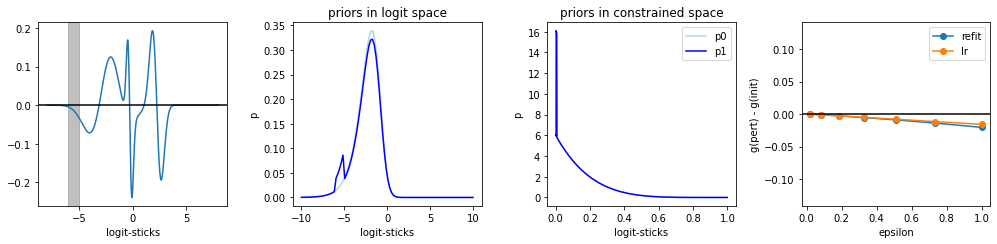

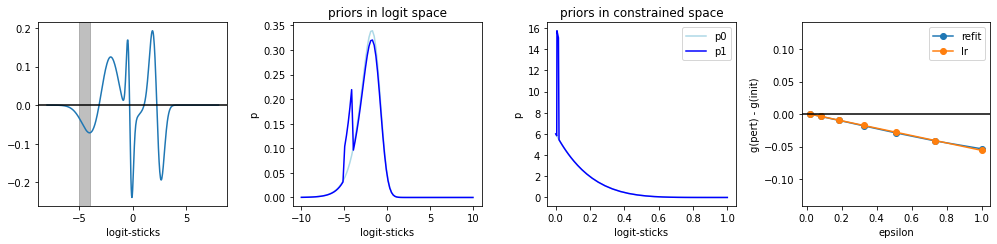

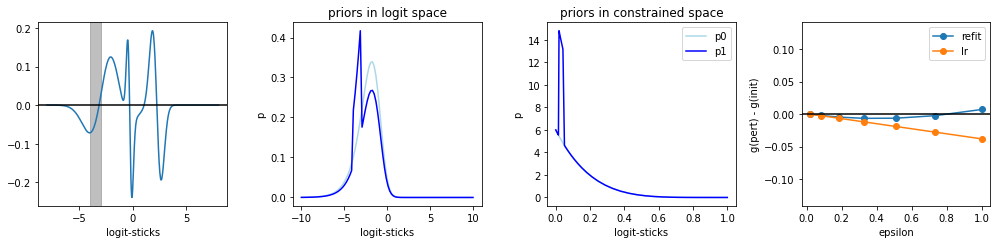

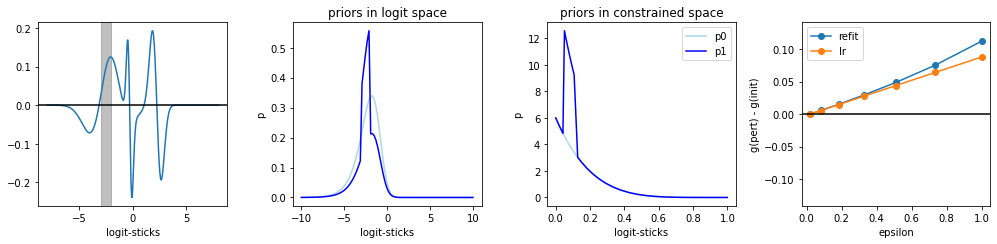

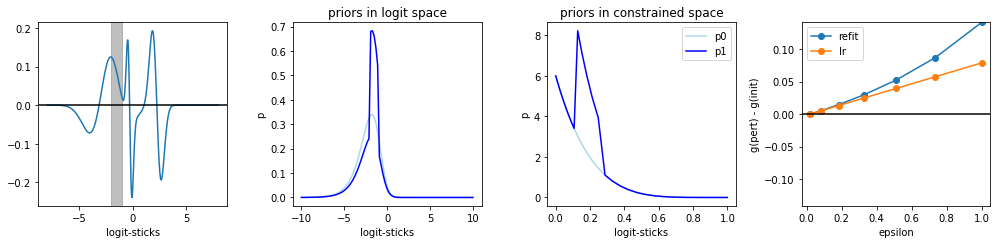

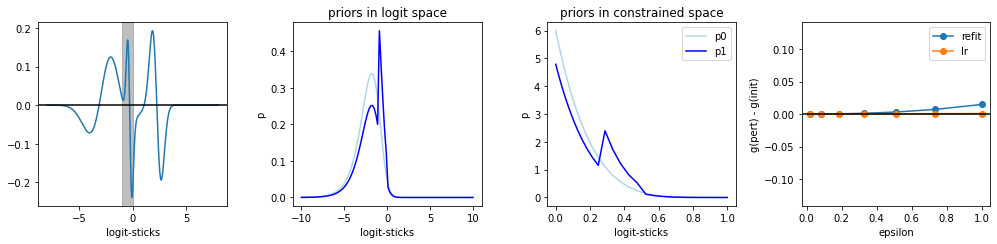

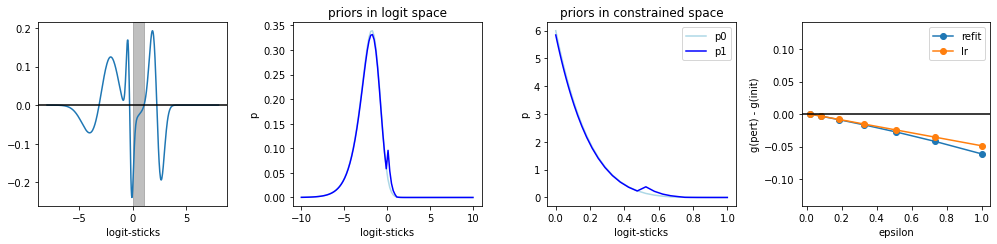

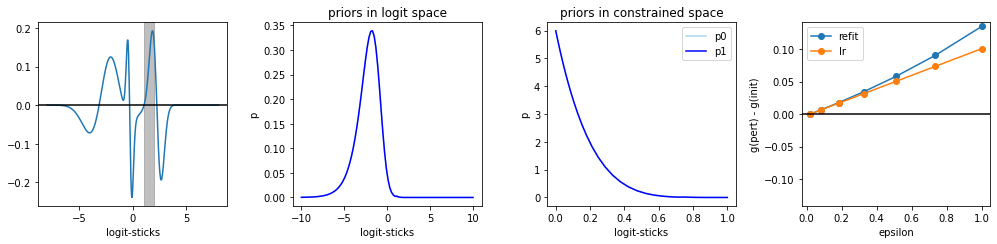

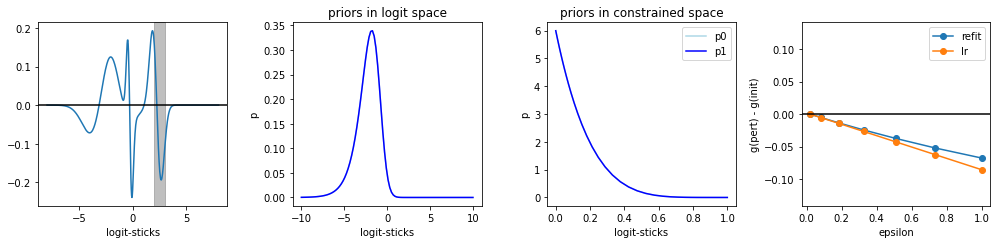

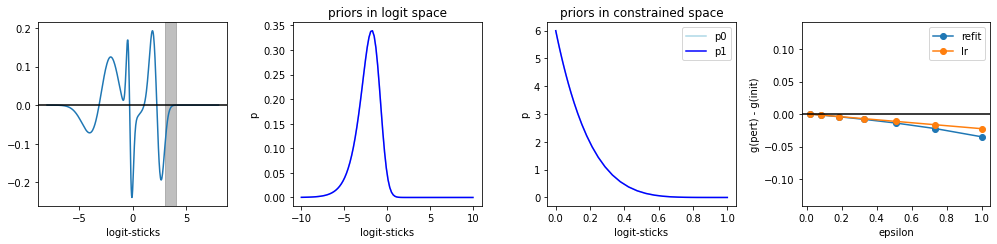

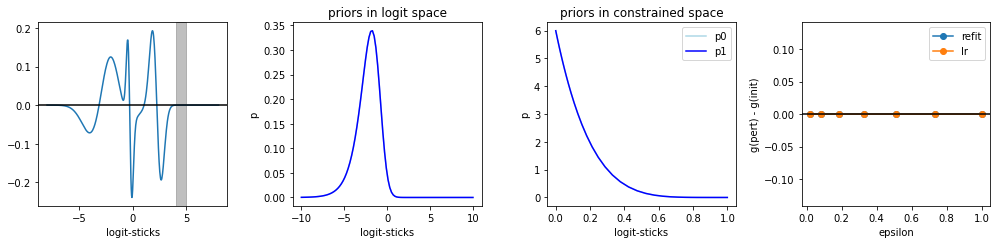

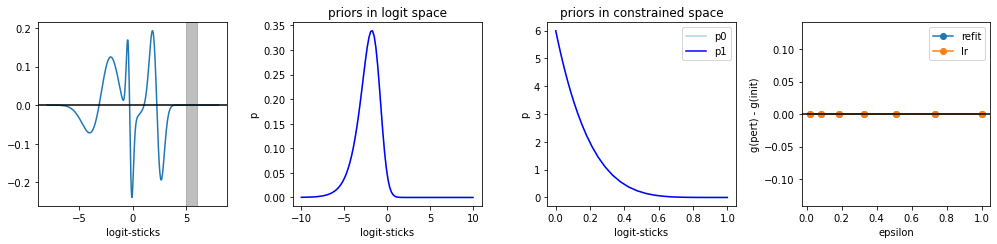

In [35]:
# ignore the warnings ... they all come from the integration function 
# that plts the perturbation. 
# doesn't actually affect results

plot_results(jax.jit(post_stats.get_n_clusters_insample),
             ghess_num_clust, 
             infl_x_prior_num_clust)

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.613749e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.602147e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.110584e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.922261e-01
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter 

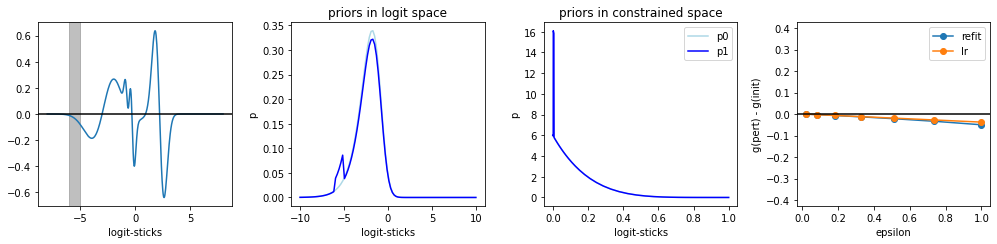

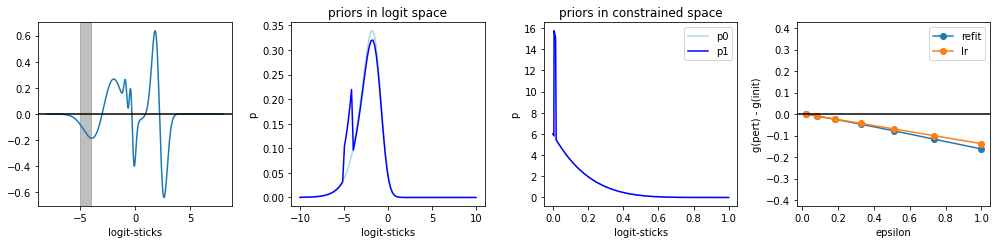

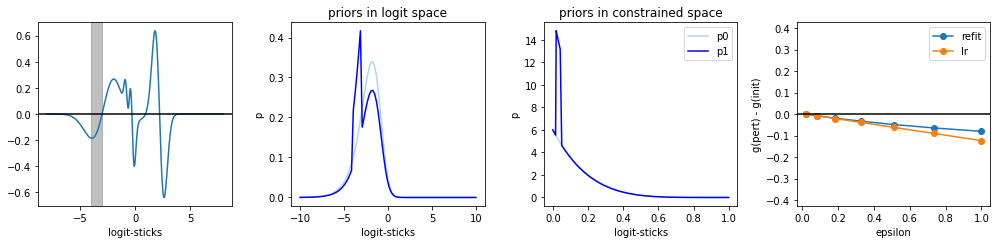

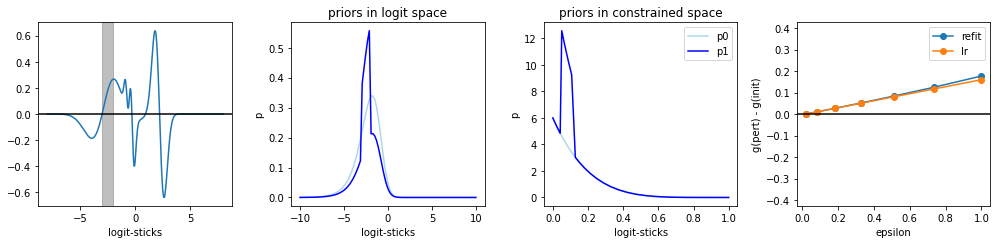

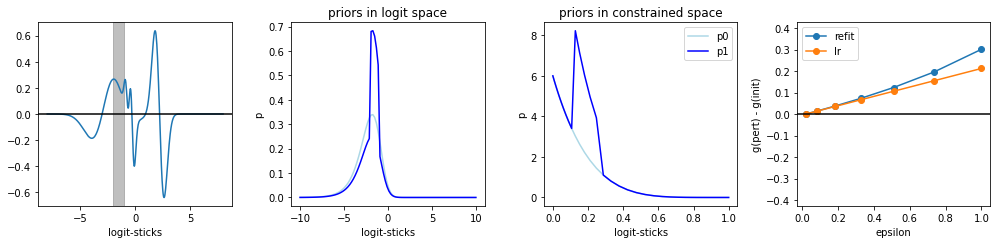

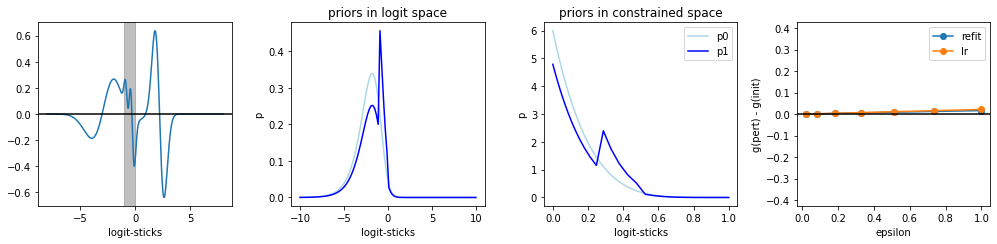

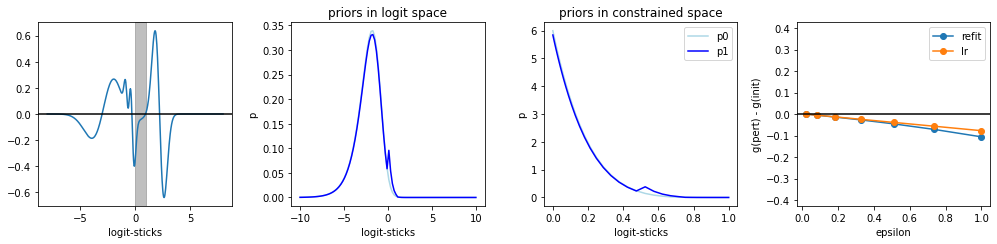

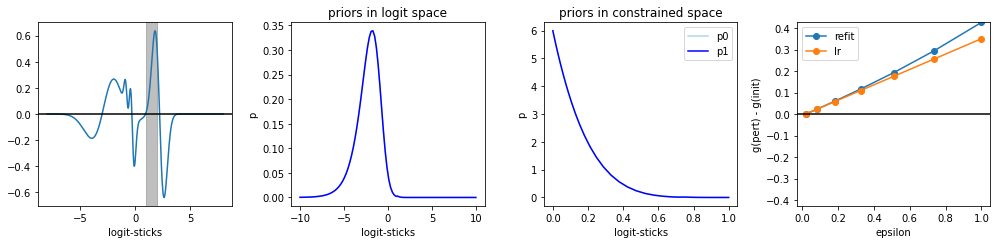

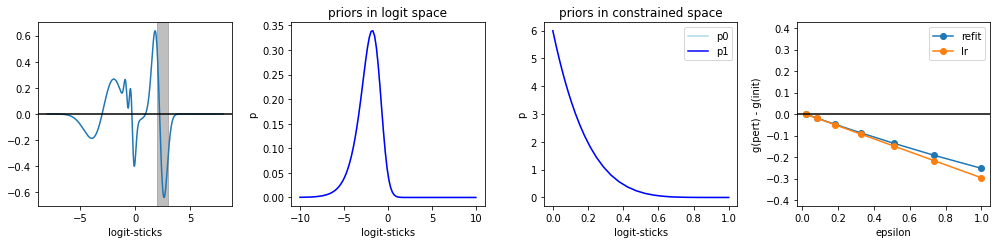

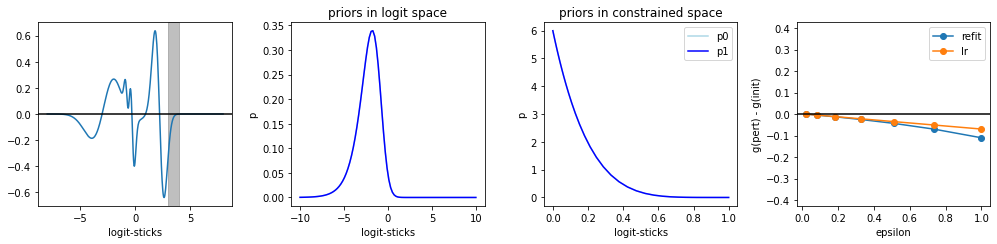

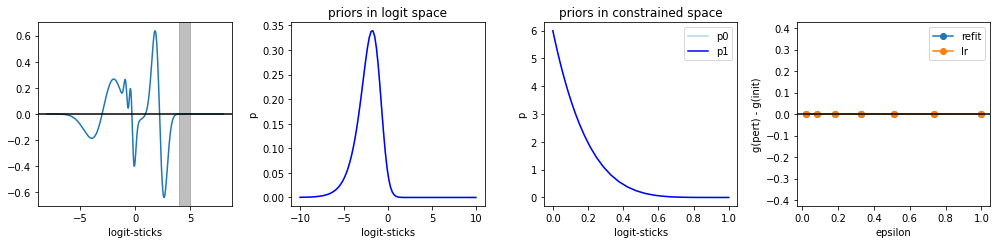

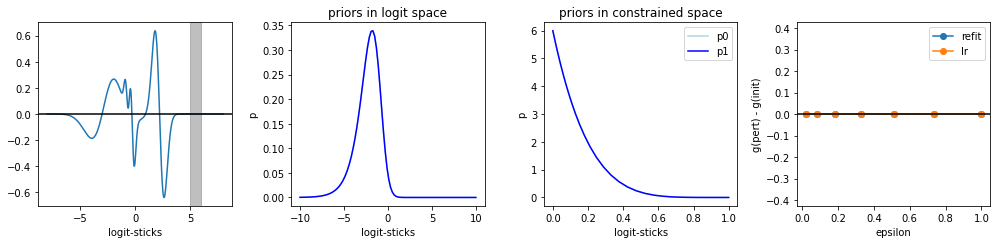

In [36]:
plot_results(jax.jit(post_stats.get_n_clusters_pred),
             ghess_num_clust_pred, 
             infl_x_prior_num_clust_pred)


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.613749e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.602147e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.110584e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.922261e-01
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter 

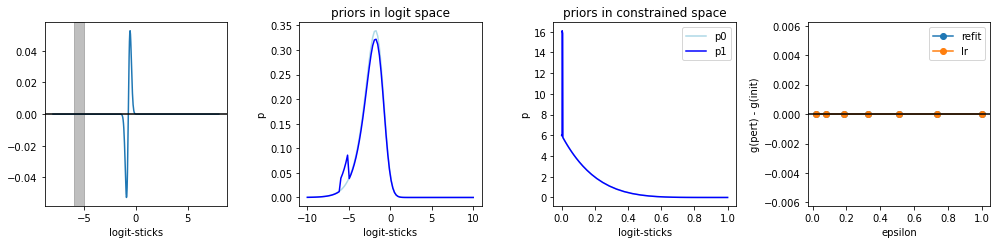

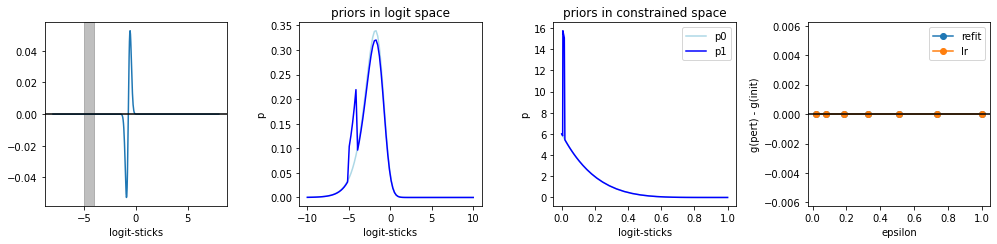

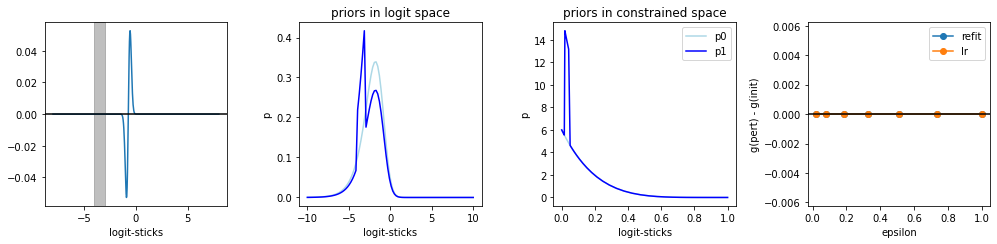

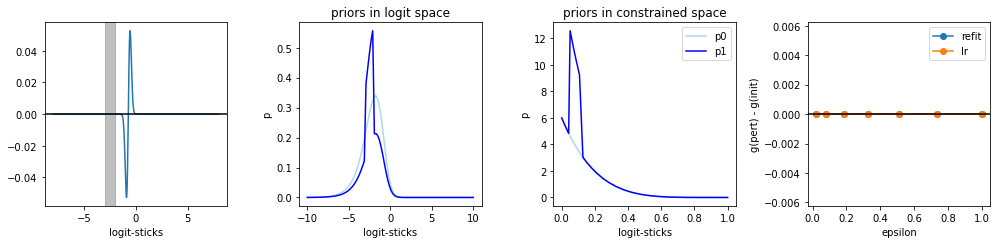

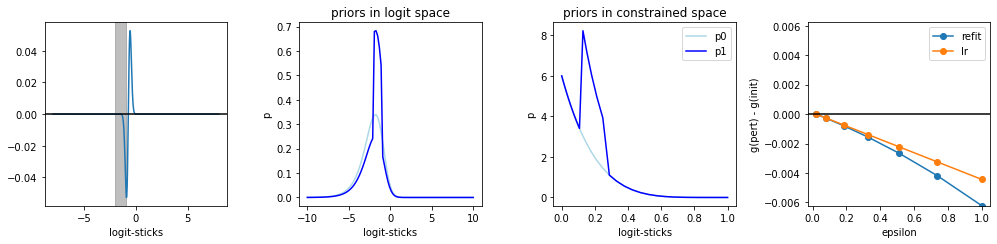

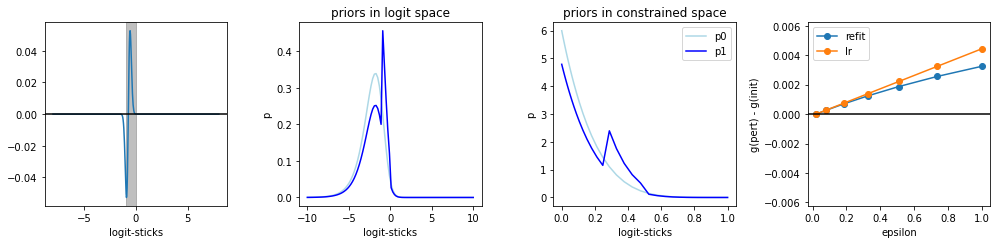

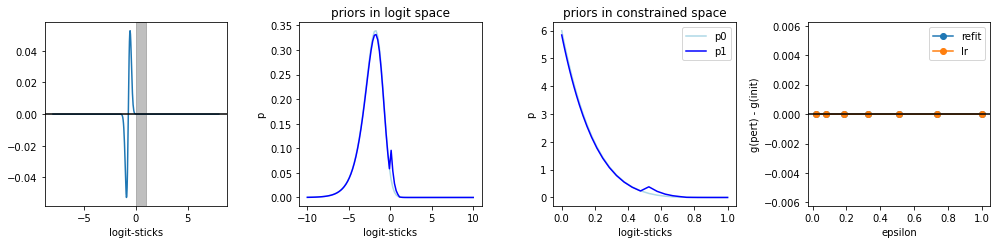

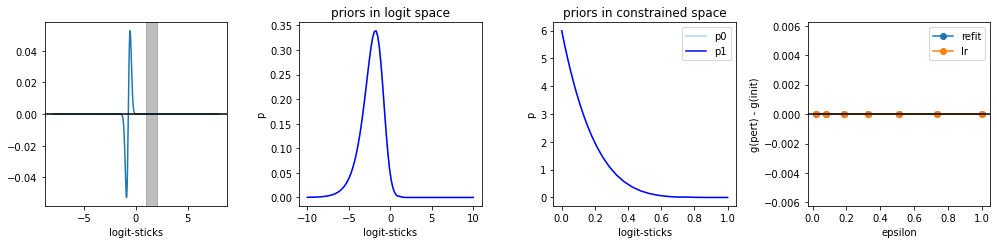

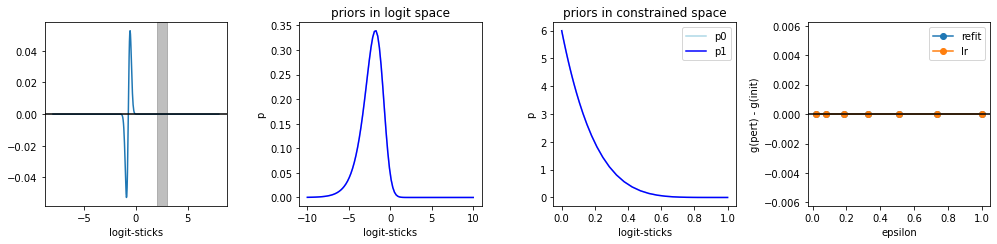

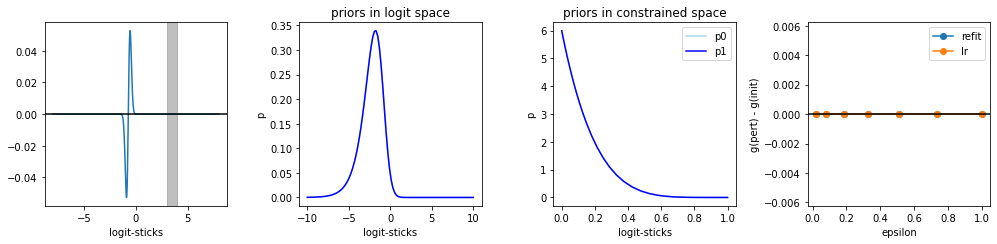

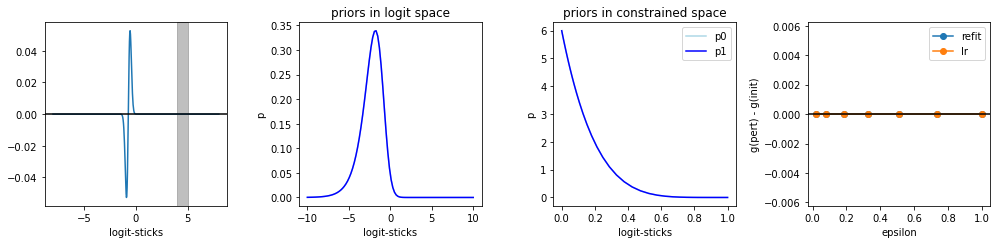

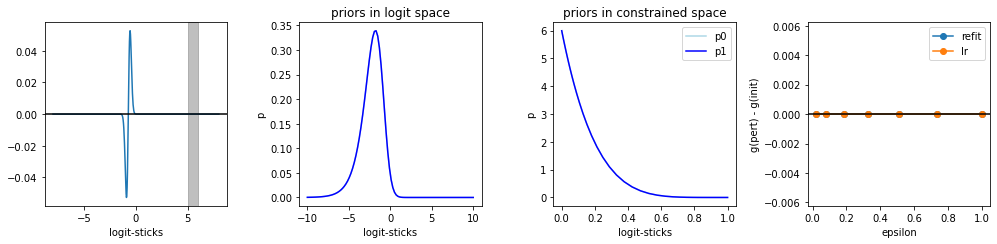

In [37]:
k = 0

plot_results(jax.jit(lambda x : post_stats.get_mixture_weight_k(x, k)), 
             e_num_ind_results['ghess{}'.format(k)], 
             e_num_ind_results['influence_grid_x_prior{}'.format(k)])


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.613749e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.602147e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 6.110584e-02
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.922261e-01
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:259: AccuracyWarning: maxiter 

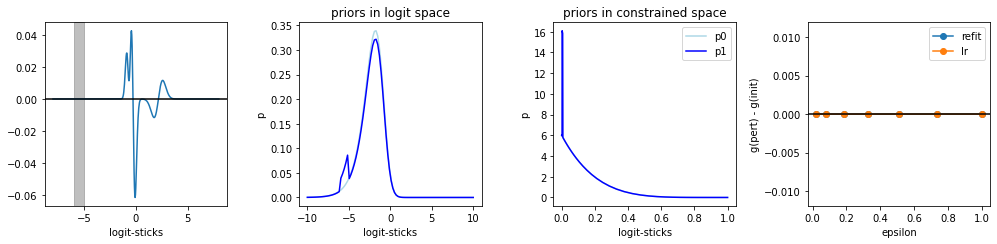

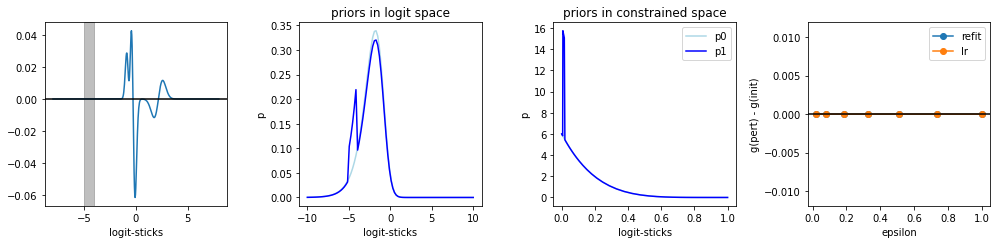

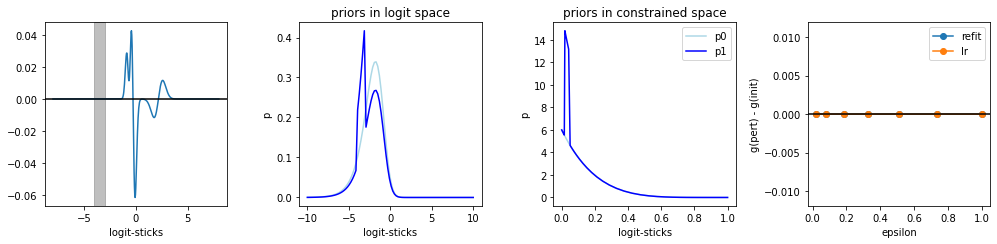

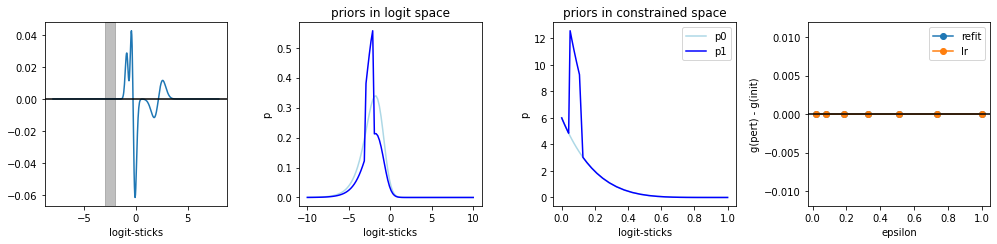

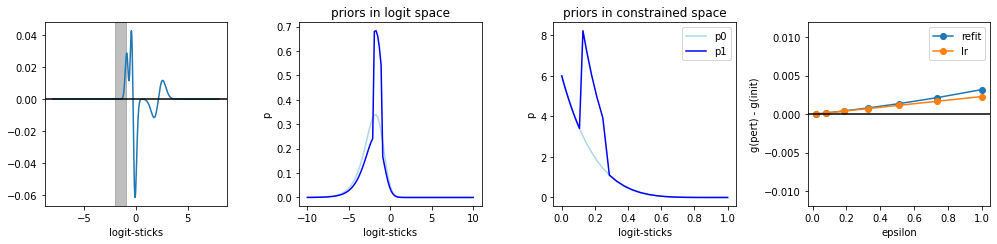

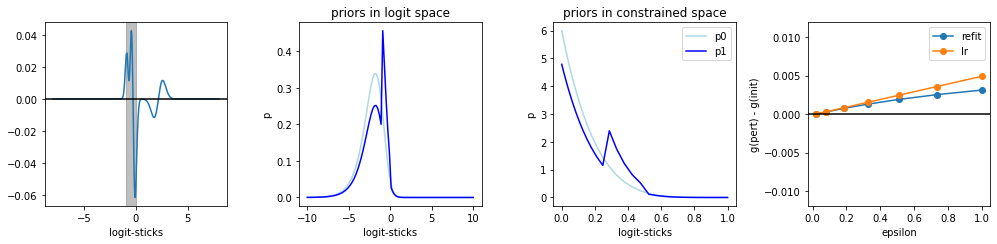

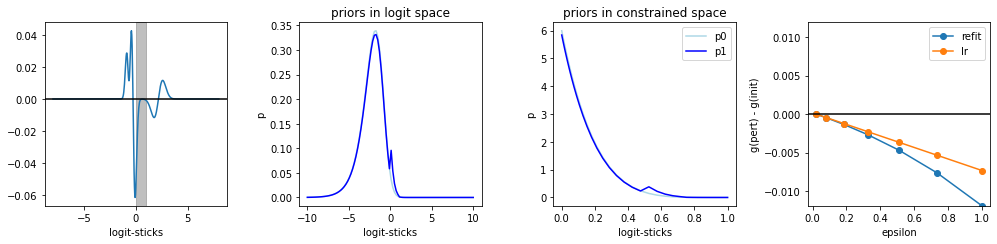

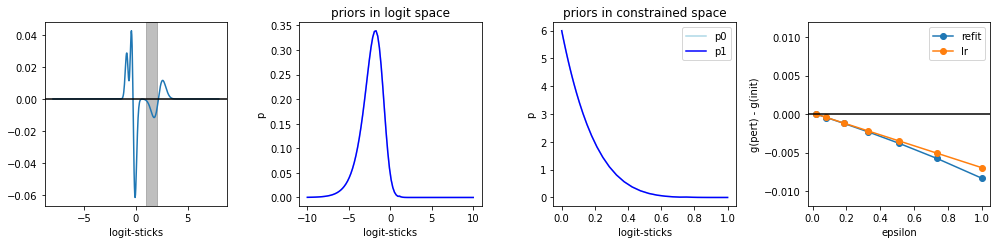

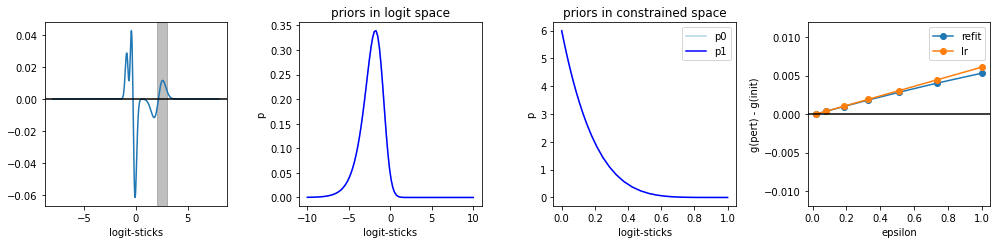

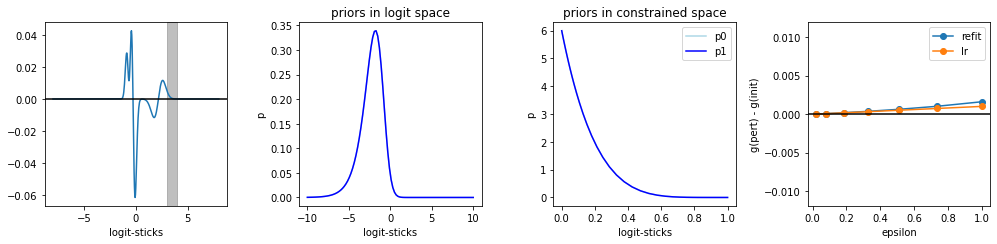

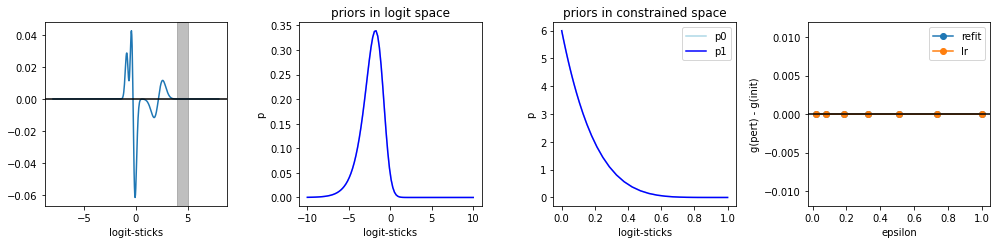

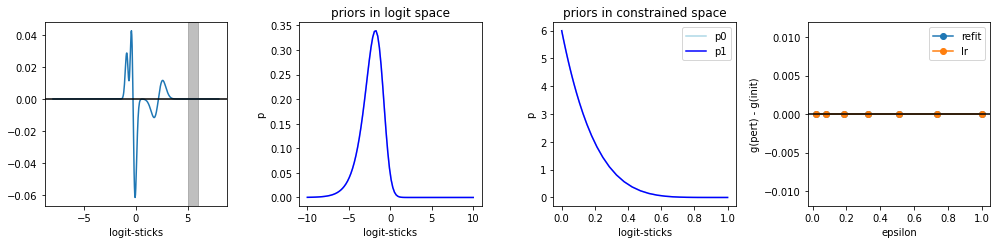

In [39]:
k = 2

plot_results(jax.jit(lambda x : post_stats.get_mixture_weight_k(x, k)), 
             e_num_ind_results['ghess{}'.format(k)], 
             e_num_ind_results['influence_grid_x_prior{}'.format(k)])
